In [2]:
import pandas as pd
import selfies as sf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from collections import Counter
import seaborn as sns
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import csv
import selfies as sf
from collections import Counter
import torch.nn as nn
import csv
import os
import pandas as pd
from cddd.inference import InferenceModel
from cddd.preprocessing import preprocess_smiles

In [3]:
!python3 example/run_qsar_test.py --model_dir cddd/pretrained_models/default_model


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0612 07:52:33.991996 136987095901696 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Traceback (most recent call last):
  File "example/run_qsar_test.py", line 94, in <module>
    tf.app.run(main=main, argv=[sys.argv[0]] + UNPARSED)
  File "/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/lib/p

In [4]:
!cddd --input smiles.smi --output descriptors.csv  --smiles_header smiles


/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/lib/python3.6/site-packages/cddd/run_cddd.py:55: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  sml_df = pd.read_table(file, header=None).rename({0:FLAGS.smiles_header, 1:"EXTREG"},
Traceback (most recent call last):
  File "/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/bin/cddd", line 8, in <module>
    sys.exit(main_wrapper())
  File "/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/lib/python3.6/site-packages/cddd/run_cddd.py", line 99, in main_wrapper
    tf.app.run(main=main, argv=[sys.argv[0]] + UNPARSED)
  File "/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/lib/python3.6/site-packages/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/lib/python3.6/site-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/home/undergra

# Smiles Embedding:
### Use cddd to encode smiles (yippeeee)

In [39]:
# create a smiles list of 6000
smiles_list = []

with open("computed_spectra.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)  # skip header line
    for i, row in enumerate(reader):
        if i >= 6000:
            break
        smiles = row[0].strip()
        try:
            smiles_list.append(smiles)
        except:
            continue

# make instance of autoencoder model
inference_model = InferenceModel(model_dir="cddd/data/default_model")

# embed the smiles
smiles_embedding = inference_model.seq_to_emb(smiles_list)

# print example to see if it works
for i in range(5):
    print(f"SMILES: {smiles_list[i]}") # full smiles
    print(f"Embedding: {smiles_embedding[i][:10]}...\n")  # print first 10 values of the embedding



INFO:tensorflow:Restoring parameters from cddd/data/default_model/model.ckpt
SMILES: CN(c1ccc(NC(=O)Nc2ccccc2)cc1)S(=O)(=O)c1ccc(-c2ccn(CCO)n2)s1
Embedding: [-0.6485799  -0.4820745  -0.29993665  0.2840209  -0.19669785  0.23079348
 -0.45663777 -0.50177956 -0.06138841  0.28148285]...

SMILES: CC(O)CC(C)C#COC#CC(C)CC(C)O
Embedding: [-0.23311913 -0.62234724 -0.14250664  0.38820195  0.27778637 -0.15076475
  0.01024481 -0.58167255 -0.23104398 -0.5806556 ]...

SMILES: Cc1cc([N+](=O)[O-])ccc1NC(=O)c1ccc(OCC(C)C)c(Br)c1
Embedding: [-0.47915938 -0.5277588   0.254828   -0.35512787 -0.01809985  0.02691496
 -0.17222045 -0.12126444  0.45158276  0.21312533]...

SMILES: COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=O)N1CC1NC12
Embedding: [ 0.95607096 -0.4094612   0.5092193   0.33736256  0.11703882  0.35932195
  0.7206423  -0.6761475  -0.16922899  0.69493043]...

SMILES: CC(C)(O)C(NC(=O)c1cnn2cc(C3CC3)cnc12)c1ccc(OC(F)(F)F)c(F)c1
Embedding: [-0.8880903   0.08556144  0.20473011  0.1794778   0.02583974 -0.440634

# Normalize & Smooth Spectra

In [50]:
import numpy as np
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler


spec_len = 1801 
spectra_list = []

with open("computed_spectra.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)
    for i, row in enumerate(reader):
        if i >= 6000:
            break
        try:
            spectrum = [float(x) for x in row[1:]]
            if len(spectrum) == spec_len:
                spectra_list.append(spectrum)
        except:
            continue


# conver to np array
spectra_array = np.array(spectra_list)

# normalize
scaler = MinMaxScaler()
normalized_spectra = scaler.fit_transform(spectra_array)

# check if normalization worked 
print("Normalized spectra shape:", normalized_spectra.shape)
print("Sample normalized spectrum:", normalized_spectra[0][:10])

# Smooth each spectrum
smoothed_spectra = [savgol_filter(spectrum, window_length=15, polyorder=3) for spectrum in normalized_spectra]

# covert back to np array
smoothed_spectra = np.array(smoothed_spectra)

# check if smoothing worked
print("Smoothed spectra shape:", smoothed_spectra.shape)
print("Example smoothed spectrum:", smoothed_spectra[0][:10])


Normalized spectra shape: (3568, 1801)
Sample normalized spectrum: [0.10808033 0.10908509 0.1097319  0.11094673 0.11241841 0.11278684
 0.11332587 0.11278429 0.11410056 0.11418134]
Smoothed spectra shape: (3568, 1801)
Example smoothed spectrum: [0.10755056 0.10928005 0.11052331 0.11138647 0.11197562 0.11239689
 0.11275636 0.11316016 0.11389765 0.11500437]


# Pad Smiles

In [138]:
def pad_embeddings(embeddings, target_dim=1802):
    current_dim = embeddings.shape[1]
    if current_dim >= target_dim:
        return embeddings[:, :target_dim]  # truncate if too long
    padding = np.ones((embeddings.shape[0], target_dim - current_dim*2))*2
    return np.concatenate([embeddings, padding, embeddings], axis=1)

X_padded = pad_embeddings(smiles_embedding, target_dim=1802)  # shape (6000, 1801)

"""def pad_to_even_dim(arr, target_dim=1802):
    if arr.shape[1] < target_dim:
        padding = np.ones((arr.shape[0], target_dim - arr.shape[1]))
        return np.concatenate([arr, padding], axis=1)
    else:
        return arr[:, :target_dim]"""

'def pad_to_even_dim(arr, target_dim=1802):\n    if arr.shape[1] < target_dim:\n        padding = np.ones((arr.shape[0], target_dim - arr.shape[1]))\n        return np.concatenate([arr, padding], axis=1)\n    else:\n        return arr[:, :target_dim]'

# Split into train & test sets :)

In [139]:
# Split into train (60%), val (20%), test (20%)
min_len = min(len(X_padded), len(Y))
X_padded = X_padded[:min_len]
Y = Y[:min_len]

X_train, X_temp, Y_train, Y_temp = train_test_split(X_padded, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Concatenate [X | Y]
Z_train = np.concatenate([X_train, Y_train], axis=1)
Z_val = np.concatenate([X_val, Y_val], axis=1)
Z_test = np.concatenate([X_test, Y_test], axis=1)



# Dataset:

In [140]:
class SmilesSpectraDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

train_loader = DataLoader(SmilesSpectraDataset(Z_train), batch_size=64, shuffle=True)
val_loader = DataLoader(SmilesSpectraDataset(Z_val), batch_size=64)   
test_loader = DataLoader(SmilesSpectraDataset(Z_test), batch_size=64)


In [143]:
sample = torch.tensor(Z_train[0][:1802], dtype=torch.float32).reshape((-1, 1802))
print(sample.shape)
sample2 = torch.rand((32, 1802))
print(sample[:,512:1024])
model(sample2)



torch.Size([1, 1802])
tensor([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
         2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
      

tensor([[0.1538, 0.4912, 0.4007,  ...,    nan,    nan,    nan],
        [0.8673, 0.5135, 0.7393,  ...,    nan,    nan,    nan],
        [0.5837, 0.6717, 0.2780,  ...,    nan,    nan,    nan],
        ...,
        [0.1179, 0.5299, 0.4148,  ...,    nan,    nan,    nan],
        [0.0615, 0.9482, 0.9723,  ...,    nan,    nan,    nan],
        [0.0941, 0.1770, 0.5320,  ...,    nan,    nan,    nan]],
       grad_fn=<CatBackward>)

In [119]:
class SIDLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, model_spectra, target_spectra):
        loss = torch.ones_like(target_spectra)

        loss = torch.mul(torch.log(torch.div(model_spectra, target_spectra)), model_spectra) \
            + torch.mul(torch.log(torch.div(target_spectra, model_spectra)), target_spectra)
        loss = torch.sum(loss, dim=1)

        return loss.mean()

In [108]:

    for batch in train_loader:
        break
    x_batch = batch[:, :1802]
    y_batch = batch[:, 1802:]
    optimizer.zero_grad()
    y_pred = model(x_batch)
    print(y_pred[:, 900:])

tensor([[0., nan, nan,  ..., nan, nan, nan],
        [0., nan, nan,  ..., nan, nan, nan],
        [0., nan, nan,  ..., nan, nan, nan],
        ...,
        [0., nan, nan,  ..., nan, nan, nan],
        [0., nan, nan,  ..., nan, nan, nan],
        [0., nan, nan,  ..., nan, nan, nan]], grad_fn=<SliceBackward>)


# INN Model: (RealNVP)

In [120]:
import torch.nn as nn
import torch

# RealNVP model (unchanged from what you wrote)
class CouplingLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        hidden = 512
        self.scale = nn.Sequential(
            nn.Linear(dim // 2, hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden, dim // 2),
            nn.ReLU()
            #nn.Tanh()
        )
        self.translate = nn.Sequential(
            nn.Linear(dim // 2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim // 2),
            nn.ReLU()
        )
    def forward(self, x, reverse=False):
        x1, x2 = x.chunk(2, dim=1)
        s, t = self.scale(x1), self.translate(x1)
        y2 = x2 * torch.exp(s) + t if not reverse else (x2 - t) * torch.exp(-s)
        return torch.cat([x1, y2], dim=1)

class RealNVP(nn.Module):
    def __init__(self, dim, num_layers=3):  # 👈 only 3 layers
        super().__init__()
        self.layers = nn.ModuleList([CouplingLayer(dim) for _ in range(num_layers)])
    def forward(self, x, reverse=False):
        for layer in (self.layers if not reverse else reversed(self.layers)):
            x = layer(x, reverse=reverse)
        return x

# Instantiate with 3 layers
input_dim = 1802
model = RealNVP(dim=input_dim, num_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = SIDLoss()

train_losses = []
val_losses = []
test_losses = []

# Training loop
for epoch in range(20):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x_batch = batch[:, :1802]
        y_batch = batch[:, 1802:]
        optimizer.zero_grad()
        y_pred = model(x_batch)
        
        #loss = loss_fn(y_pred[:, 800:], y_batch[:, 800:])
        loss = loss_fn(y_pred, y_batch)
        print(y_pred)
        print(y_batch)
        print(loss)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss)

    # Eval on val and test
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            x_batch = batch[:, :1802]
            y_batch = batch[:, 1802:]
            y_pred = model(x_batch)
            val_loss += loss_fn(y_pred[:, 800:], y_batch[:, 800:]).item()
        val_losses.append(val_loss)

        test_loss = 0
        for batch in test_loader:
            x_batch = batch[:, :1802]
            y_batch = batch[:, 1802:]
            y_pred = model(x_batch)
            test_loss += loss_fn(y_pred[:, 800:], y_batch[:, 800:]).item()
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}: Train Loss = {total_loss:.4f}, Val Loss = {val_loss:.4f}, Test Loss = {test_loss:.4f}")


tensor([[ 0.8934,  0.0882, -0.1884,  ...,  1.3110,  0.5481,  1.6134],
        [-0.7205,  0.2731, -0.5231,  ...,  0.2383,  0.5150, -0.5727],
        [-0.8543, -0.1021,  0.1381,  ...,  0.2090,  0.2775,  0.4625],
        ...,
        [-0.8867, -0.4088, -0.5815,  ...,  0.6586,  0.6793,  0.2200],
        [ 0.1606, -0.4492,  0.7752,  ..., -0.0997,  0.2966,  0.9169],
        [-0.4706, -0.3259,  0.4242,  ..., -0.4137,  0.9357,  0.3206]],
       grad_fn=<CatBackward>)
tensor([[0.0973, 0.0982, 0.0989,  ..., 0.0873, 0.0862, 0.0000],
        [0.0734, 0.0744, 0.0751,  ..., 0.0662, 0.0653, 0.0000],
        [0.0852, 0.0860, 0.0865,  ..., 0.0616, 0.0605, 0.0000],
        ...,
        [0.1431, 0.1445, 0.1453,  ..., 0.0559, 0.0543, 0.0000],
        [0.0653, 0.0667, 0.0677,  ..., 0.1556, 0.1560, 0.0000],
        [0.0614, 0.0622, 0.0628,  ..., 0.1004, 0.0993, 0.0000]])
tensor(nan, grad_fn=<MeanBackward0>)
tensor([[-0.6590,  0.5302, -0.4639,  ...,     nan,     nan,     nan],
        [ 0.5757,  0.1780,  0.2

KeyboardInterrupt: 

In [78]:
input_dim = 1802
model = RealNVP(dim=input_dim, num_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = SIDLoss()

In [82]:
s1 = torch.rand((32,1802))
s1 = s1/10000
model(s1)

tensor([[2.6505e-05, 8.1909e-05, 6.1232e-05,  ..., 2.8554e-02, 3.7877e-02,
         7.7821e-03],
        [4.7800e-05, 3.7571e-05, 1.8801e-05,  ..., 2.8569e-02, 3.7874e-02,
         7.7865e-03],
        [2.5125e-05, 6.3787e-05, 4.0418e-05,  ..., 2.8524e-02, 3.7803e-02,
         7.7103e-03],
        ...,
        [6.6687e-05, 5.6700e-05, 8.4251e-05,  ..., 2.8569e-02, 3.7921e-02,
         7.7148e-03],
        [9.0995e-05, 5.4451e-05, 9.9603e-05,  ..., 2.8514e-02, 3.8144e-02,
         7.7443e-03],
        [6.6049e-05, 2.5114e-05, 3.3071e-05,  ..., 2.8600e-02, 3.8140e-02,
         7.7509e-03]], grad_fn=<CatBackward>)

# Model Evaluation 

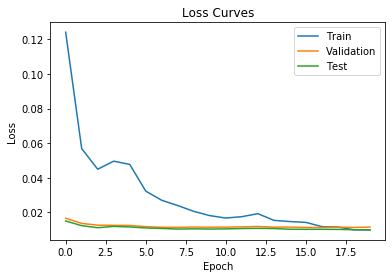

In [67]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.plot(test_losses, label="Test")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

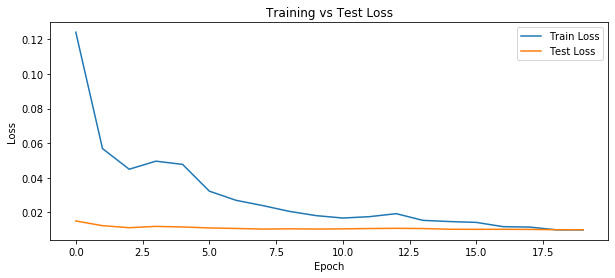

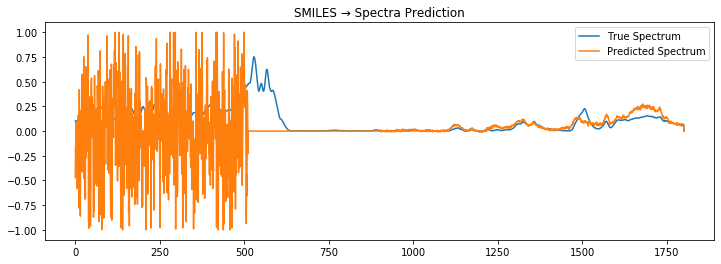

In [68]:
# plot loss graph
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.show()

# plot predicted vs true spectrum
model.eval()
with torch.no_grad():
    y_pred_test = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

idx = 0
plt.figure(figsize=(12, 4))
plt.plot(Y_test[idx], label="True Spectrum")
plt.plot(y_pred_test[idx], label="Predicted Spectrum")
plt.title("SMILES → Spectra Prediction")
plt.legend()
plt.show()

plt.show()